# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

# Create copies of both datasets to work with
azdias_clean = azdias.copy()
feat_info_clean = feat_info.copy()

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_clean.shape


(891221, 85)

In [4]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias_clean.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info_clean.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
for attribute in feat_info_clean['attribute']:
    # Convert the string representation of missing values into an actual list
    missing_values = feat_info_clean.loc[feat_info_clean['attribute'] == attribute, 'missing_or_unknown'].iloc[0]
    missing_values = missing_values.strip('[]').split(',')

    # Convert string representations of integers to actual integers
    missing_values = [int(value) if (value.isdigit() or value[1:].isdigit()) else value for value in missing_values]

    # Replace missing or unknown values with NaN in azdias_clean
    if attribute in azdias_clean.columns:
        azdias_clean[attribute] = azdias_clean[attribute].replace(missing_values, np.nan)

In [11]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Count the number of missing values per column
missing_values_count = azdias_clean.isna().sum()

# Calculate the percentage of missing data in each column
total_rows = len(azdias_clean)
missing_percentage = (missing_values_count / total_rows) * 100

# Sort the columns by the percentage of missing data in descending order
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

# Display the results
print(missing_percentage_sorted)


TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

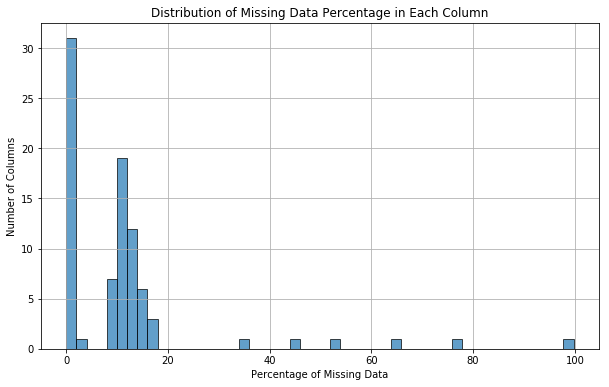

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10, 6))
plt.hist(missing_percentage, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Missing Data Percentage in Each Column')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.grid(True)
plt.show()


In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Define the threshold for removing columns
threshold_percentage = 34

# Identify columns that have missing data above this threshold
outlier_columns = missing_percentage[missing_percentage > threshold_percentage].index

# Remove these columns from the DataFrame
azdias_clean.drop(columns=outlier_columns, inplace=True)


In [15]:
azdias_clean.shape

(891221, 79)

In [16]:
# Remove outlier columns from feat_info dataset for later usage 
feat_info_clean = feat_info_clean[~feat_info_clean.attribute.isin(outlier_columns)]
feat_info_clean.shape

(79, 4)

#### Discussion 1.1.2: Assess Missing Data in Each Column

79 of the 85 features all have missing value percentages of less than 20. AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, AND KBA05_MAUMAX had missing value percentages ranging from 34 all the way to 99. Most of the features are seemingly obscure, so it makes sense that much of that data would be missing. The exception being year of birth. They don't seem to be similar in any way, either. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
# Calculate the missing data per row
row_missing_data = azdias_clean.isna().sum(axis=1)


Text(0,0.5,'Number of rows')

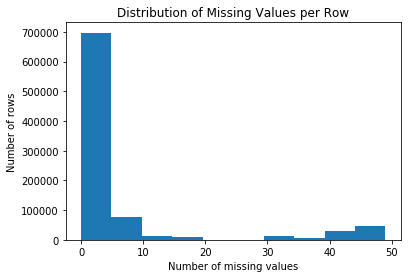

In [18]:
# Distribution of number of missing values in rows
plt.hist(row_missing_data)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of missing values')
plt.ylabel('Number of rows')

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Divide the dataset into two subsets
azdias_under = azdias_clean[row_missing_data <= threshold_percentage]
azdias_over = azdias_clean[row_missing_data > threshold_percentage]


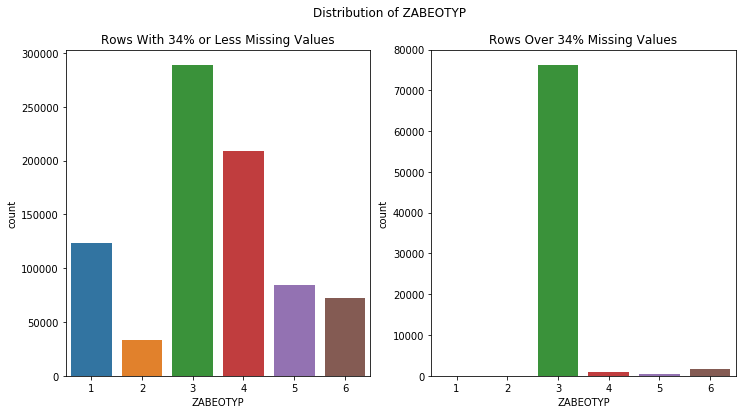

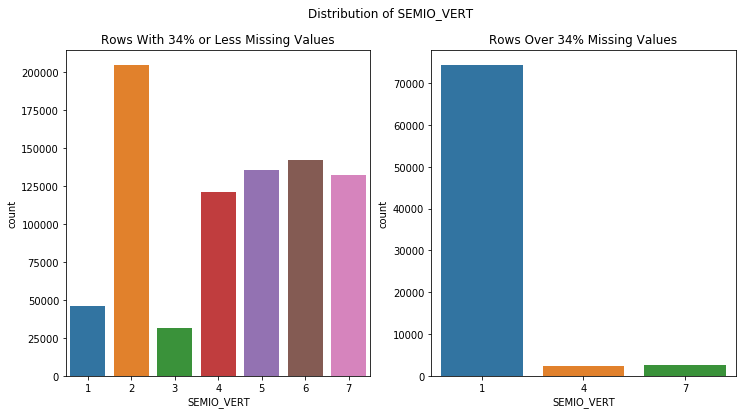

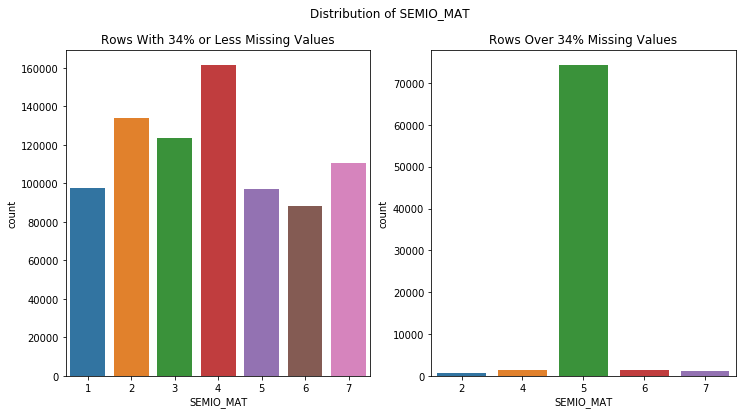

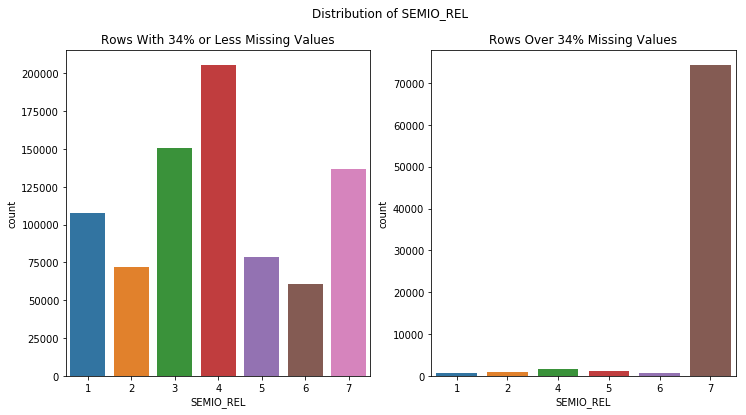

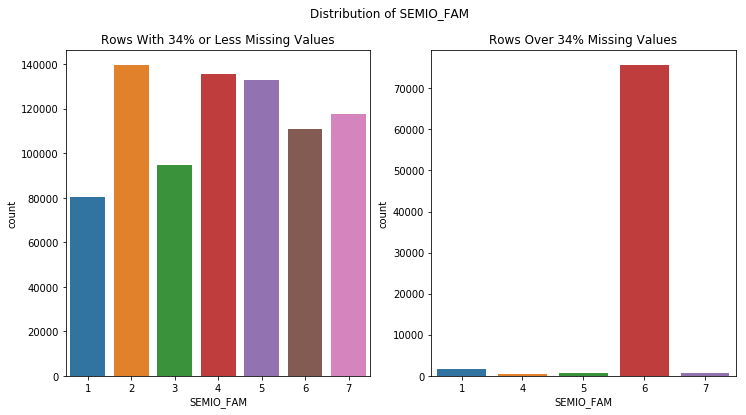

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# Select columns with the least missing data
columns_for_comparison = list(azdias_under.isna().sum().sort_values().index[:5])

# Create a function to compare the distributions
def compare_distributions(column):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data=azdias_under)
    plt.title('Rows With 34% or Less Missing Values')

    plt.subplot(1, 2, 2)
    sns.countplot(x=column, data=azdias_over)
    plt.title('Rows Over 34% Missing Values')

    plt.suptitle(f'Distribution of {column}')
    plt.show()
    
# Call the function to create a visualization comparing distributions
for column in columns_for_comparison:
    compare_distributions(column)

In [30]:
azdias_clean = azdias_under

#### Discussion 1.1.3: Assess Missing Data in Each Row

It can be noted that all of these columns have wider ranges for their values, such as -1:9 versus -1:1. As we can see, the data with more missing values is qualitatively different than the data with less missing values. We should note that this data is special as we go further into our analysis. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?
# Count the number of features of each data type
feat_info_clean.type.value_counts()



ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_feats = list(feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute'])
cat_feats

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [33]:
# Create an empty list 
binary_feats = []
multi_feats = []

# Loop through the categorical feature list
for feature in cat_feats:
    if feature in azdias_clean.columns:
        # Count unique values in the column
        unique_values = azdias_clean[feature].nunique()

        # If there are exactly two unique values, consider it binary
        if unique_values == 2:
            binary_feats.append(feature)
        # If there are more than 2 unique values, consider it multivariate
        elif unique_values > 2:
            multi_feats.append(feature)
            

In [34]:
binary_feats

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [35]:
# Create an empty list
non_num_bfeats = []

# Loop through the binary feature list
for feature in binary_feats:
    if feature in azdias_clean.columns:
        # Get unique values of the feature
        unique_values = azdias_clean[feature].dropna().unique()

        # Check if the unique values are non-numeric 
        if all(isinstance(value, str) for value in unique_values):
            non_num_bfeats.append(feature)
            
non_num_bfeats

['OST_WEST_KZ']

In [36]:
# Create a for loop to generate dummies for all non-numerical binary features
for feature in non_num_bfeats:
    # Generate dummies for each feature
    dummies = pd.get_dummies(azdias_clean[feature], prefix=feature)
    # Concatenate the dummies to the original DataFrame
    azdias_clean = pd.concat([azdias_clean, dummies], axis=1)
    # Optionally, drop the original non-numeric feature column if you don't need it anymore
    azdias_clean.drop(columns=feature, inplace=True)

In [37]:
multi_feats

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [38]:
azdias_clean.shape

(812077, 80)

In [39]:
# Create an empty list
drop_feats = []

# Loop through multi_feats
for feature in multi_feats:
    if feature in azdias_clean.columns:
        # Count unique values in the column
        unique_values = azdias_clean[feature].nunique()

        # If there are 10 or more unique values, add the feature to the list
        if unique_values >= 10:
            drop_feats.append(feature)
            
# Drop features with 10 or more variables
azdias_clean.drop(drop_feats, axis=1, inplace=True)

In [40]:
azdias_clean.shape

(812077, 76)

In [41]:
# Drop the same variables from the list multi_feats
for feature in drop_feats:
    if feature in multi_feats:
        multi_feats.remove(feature)

In [42]:
multi_feats

['CJT_GESAMTTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [43]:
# Re-encode the multivariate features with dummy variables
azdias_clean = pd.get_dummies(data=azdias_clean, columns=multi_feats)

In [44]:
azdias_clean.shape

(812077, 118)

#### Discussion 1.2.1: Re-Encode Categorical Features

I separated the categorical features up into binary and multivariate groups. I re-encoded the only binary feature using non-numerical values using dummies. I dropped any of the multivariate features that had 10 or more variables for simplicity and resource considerations. Then, I got dummy variables for the remaining multivariate features. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [45]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Define mapping for the decade variable
decade_mapping = {
    -1: None, 0: None, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
    8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
}

# Define mapping for the movement variable
movement_mapping = {
    -1: None, 0: None, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1,
    8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
}

# Map the original 'PRAEGENDE_JUGENDJAHRE' values to the new decade and movement variables
azdias_clean['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
azdias_clean['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

# Programatically inspect the changes
sample_rows = azdias_clean.sample(5)
sample_rows[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_decade', 'PRAEGENDE_JUGENDJAHRE_movement']]

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement
782144,8.0,70.0,0.0
101631,9.0,70.0,1.0
13187,14.0,90.0,0.0
509385,8.0,70.0,0.0
53779,14.0,90.0,0.0


In [46]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Replace non-numeric characters with NaN
azdias_clean['CAMEO_INTL_2015'] = pd.to_numeric(azdias_clean['CAMEO_INTL_2015'], errors='coerce')

# Now extract the tens and ones place values
azdias_clean['CAMEO_INTL_2015_wealth'] = azdias_clean['CAMEO_INTL_2015'].dropna().astype(str).str[0].astype(float)
azdias_clean['CAMEO_INTL_2015_life_stage'] = azdias_clean['CAMEO_INTL_2015'].dropna().astype(str).str[1].astype(float)

In [47]:
# Programatically inspect the changes
sample_rows = azdias_clean.sample(5)
sample_rows[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage']]

,CAMEO_INTL_2015,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
113841,51.0,5.0,1.0
122378,24.0,2.0,4.0
663847,41.0,4.0,1.0
654713,41.0,4.0,1.0
792651,51.0,5.0,1.0


In [48]:
azdias_clean.shape

(812077, 122)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I've decided to drop the mixed features, aside from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 from the dataset for simplicity. I split the first feature, PRAEGENDE_JUGENDJAHRE, into two variables by mapping out each to movement and decade. The second feature, CAMEO_INTL_2015, was also split into two variables. This time I extracted the 10's and 1's place and assigned them to the new wealth and life_stage categories. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [49]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [50]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# Drop remaining mixed variable features 
mixed_features = feat_info_clean[feat_info_clean['type'] == 'mixed']['attribute'].values
azdias_clean.drop(mixed_features, axis=1, inplace=True)


In [51]:
azdias_clean.shape

(812077, 116)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

# Create a copy of both datasets to work with
azdias_clean = azdias.copy()
feat_info_clean = feat_info.copy()

In [2]:
def clean_data(df1, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    Parameters:
    df1 (DataFrame): A DataFrame containing population demographics data
    df2 (DataFrame): A DataFrame containing feature data found within the population data
    
    Returns:
    df1 (DataFrame): A cleaned DataFrame containing population demographics data
    df2 (DataFrame): A cleaned DataFrame containing feature data found within the population data
    """
    
    # Identify missing or unknown data values and convert them to NaNs.
    for attribute in df2['attribute']:
        # Convert the string representation of missing values into an actual list
        missing_values = df2.loc[df2['attribute'] == attribute, 'missing_or_unknown'].iloc[0]
        missing_values = missing_values.strip('[]').split(',')
        # Convert string representations of integers to actual integers
        missing_values = [int(value) if (value.isdigit() or value[1:].isdigit()) else value for value in missing_values]
        # Replace missing or unknown values with NaN in df1
        if attribute in df1.columns:
            df1[attribute] = df1[attribute].replace(missing_values, np.nan)
    
    # Count the number of missing values per column
    missing_values_count = df1.isna().sum()
    # Calculate the percentage of missing data in each column
    total_rows = len(df1)
    missing_percentage = (missing_values_count / total_rows) * 100
    
    # Define the threshold for removing columns
    threshold_percentage = 34
    # Identify columns that have missing data above this threshold
    outlier_columns = missing_percentage[missing_percentage > threshold_percentage].index
    
    # Remove these columns from df1
    df1.drop(columns=outlier_columns, inplace=True)
    # Remove outlier columns from df2 for later usage 
    df2 = df2[~df2.attribute.isin(outlier_columns)]

    # Calculate the missing data per row
    row_missing_data = df1.isna().sum(axis=1)
    # Drop rows with data missing above the threshold
    df1 = df1[row_missing_data <= threshold_percentage]
    
    # Create a list of categorical features
    cat_feats = list(df2[df2['type'] == 'categorical']['attribute'])
    # Create empty lists for binary and multivariate features
    binary_feats = []
    multi_feats = []
    # Loop through the categorical feature list
    for feature in cat_feats:
        if feature in df1.columns:
            # Count unique values in the column
            unique_values = df1[feature].nunique()
            # If there are exactly two unique values, consider it binary
            if unique_values == 2:
                binary_feats.append(feature)
            # If there are more than 2 unique values, consider it multivariate
            elif unique_values > 2:
                multi_feats.append(feature)
    # Create an empty list for non-numerical binary features
    non_num_bfeats = []
    # Loop through the binary feature list
    for feature in binary_feats:
        if feature in df1.columns:
            # Get unique values of the feature
            unique_values = df1[feature].dropna().unique()
            # Check if the unique values are non-numeric
            if all(isinstance(value, str) for value in unique_values):
                non_num_bfeats.append(feature)
    # Create a for loop to generate dummies for all non-numerical binary features
    for feature in non_num_bfeats:
        # Generate dummies for each feature
        dummies = pd.get_dummies(df1[feature], prefix=feature)
        # Concatenate the dummies to the original DataFrame
        df1 = pd.concat([df1, dummies], axis=1)
        # Drop the original non-numeric feature column 
        df1.drop(columns=feature, inplace=True)
        
    # Create an empty list for features to drop
    drop_feats = []
    # Loop through multi_feats
    for feature in multi_feats:
        if feature in df1.columns:
            # Count unique values in the column
            unique_values = df1[feature].nunique()
            # If there are 10 or more unique values, add the feature to the list
            if unique_values >= 10:
                drop_feats.append(feature)
    # Drop features with 10 or more variables
    df1.drop(drop_feats, axis=1, inplace=True)
    # Drop the same variables from the list multi_feats
    for feature in drop_feats:
        if feature in multi_feats:
            multi_feats.remove(feature)
    # Re-encode the multivariate features with dummy variables
    df1 = pd.get_dummies(data=df1, columns=multi_feats)
    
    # Define mapping for the decade variable in the 'PRAEGENDE_JUGENDJAHRE' feature
    decade_mapping = {
    -1: None, 0: None, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
    8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
    }
    # Define mapping for the movement variable in the 'PRAEGENDE_JUGENDJAHRE' feature
    movement_mapping = {
    -1: None, 0: None, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1,
    8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
    }
    # Map the original 'PRAEGENDE_JUGENDJAHRE' values to the new decade and movement variables
    df1['PRAEGENDE_JUGENDJAHRE_decade'] = df1['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    df1['PRAEGENDE_JUGENDJAHRE_movement'] = df1['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
    # Replace non-numeric characters with NaN in the 'CAMEO_INTL_2015' feature
    df1['CAMEO_INTL_2015'] = pd.to_numeric(df1['CAMEO_INTL_2015'], errors='coerce')
    # Now extract the tens and ones place values
    df1['CAMEO_INTL_2015_wealth'] = df1['CAMEO_INTL_2015'].dropna().astype(str).str[0].astype(float)
    df1['CAMEO_INTL_2015_life_stage'] = df1['CAMEO_INTL_2015'].dropna().astype(str).str[1].astype(float)
    
    # Drop remaining mixed variable features 
    mixed_features = df2[df2['type'] == 'mixed']['attribute'].values
    df1.drop(mixed_features, axis=1, inplace=True)
    
    return (df1, df2)

In [3]:
azdias_clean, feat_info_clean = clean_data(azdias_clean, feat_info_clean)

In [4]:
azdias_clean.shape

(812077, 116)

In [5]:
feat_info_clean.shape

(79, 4)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [6]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Check for total number of NaN values
total_nans = azdias_clean.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {total_nans}")

Total NaN values in the DataFrame: 1167582


In [7]:
# Import the SimpleImputer library
from sklearn.preprocessing import Imputer

# Create an instance of the imputer
imputer = Imputer(strategy='most_frequent')

# Use the imputer to transform the data
matrix_values = imputer.fit_transform(azdias_clean)
azdias_clean = pd.DataFrame(matrix_values, columns=azdias_clean.columns)


In [8]:
# Check for total number of NaN values
total_nans = azdias_clean.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {total_nans}")

Total NaN values in the DataFrame: 0


In [9]:
# Apply feature scaling to the general population demographics data.
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Create and instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
azdias_scaled = scaler.fit_transform(azdias_clean)

# Convert scaled data back to DataFrame
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_clean.columns)


### Discussion 2.1: Apply Feature Scaling

I have filled all NaN values with the mode of said values using the imputer instance. I then scaled all of the features to a mean of 0 and a standard deviation of 1. This was done using the StandardScaler instance. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [10]:
# Apply PCA to the data.
# Import PCA for component analysis
from sklearn.decomposition import PCA

# Set a number for components
n_components = azdias_scaled.shape[1]
# Create an instance for PCA
pca = PCA(n_components=n_components)
# Fit the data for PCA
data_pca = pca.fit(azdias_scaled)


Text(0.5,1,'Explained Variance Per Principal Component')

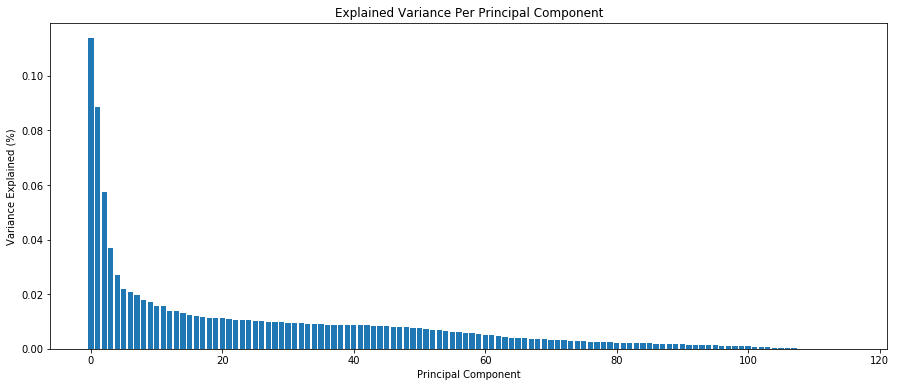

In [11]:
# Investigate the variance accounted for by each principal component.

components = np.arange(n_components)
exp_variance = pca.explained_variance_ratio_
plt.figure(figsize=(15, 6))
plt.bar(components, exp_variance)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance Per Principal Component")


Text(0.5,1,'Cumulative Explained Variance Per Principal Component')

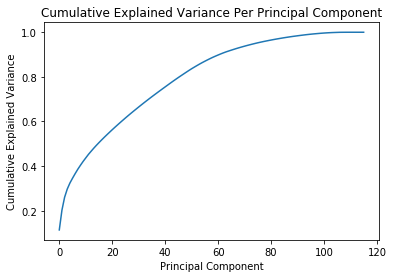

In [12]:
cum_vals = np.cumsum(exp_variance)
plt.plot(components, cum_vals)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Per Principal Component")

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Set the number of components for final PCA
n_components = azdias_scaled.shape[1]//2
# Create another instance for PCA
pca = PCA(n_components=n_components)
# Fit the data for PCA
data_pca = pca.fit_transform(azdias_scaled)


Text(0.5,1,'Explained Variance Per Principal Component')

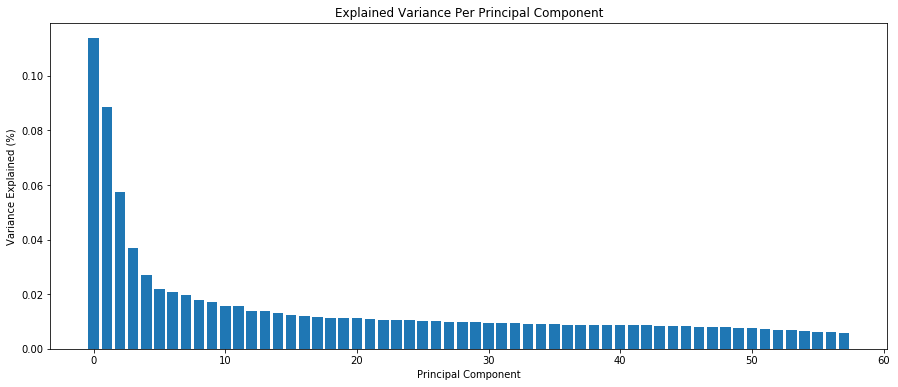

In [14]:
components = np.arange(n_components)
exp_variance = pca.explained_variance_ratio_
plt.figure(figsize=(15, 6))
plt.bar(components, exp_variance)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance Per Principal Component")

Text(0.5,1,'Cumulative Explained Variance Per Principal Component')

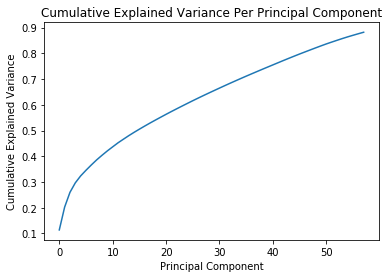

In [15]:
cum_vals = np.cumsum(exp_variance)
plt.plot(components, cum_vals)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Per Principal Component")

### Discussion 2.2: Perform Dimensionality Reduction

I originally ran the component analysis with all features. Apon looking at the cumulative explained variance I decided to only use half of the components, as more than that would use up unnecessary resources for minimal gain. With 58 components we can account for roughly 88% of the variance for our data. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [16]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights_to_features(pca_component, feature_names):
    """
    Maps the weights of a PCA component to corresponding feature names and returns them sorted by 
    weight.
    
    Parameters:
    pca_component (array): A single component from a trained PCA model.
    feature_names (list): The list of feature names corresponding to the PCA component weights.
    
    Returns:
    sorted_weights (list): A list of (feature, weight) tuples.
    """
    feature_weights = dict(zip(feature_names, pca_component))
    # Sort by absolute weight in descending order
    sorted_weights = sorted(feature_weights.items(), key=lambda kv: abs(kv[1]), reverse=True)
    return sorted_weights

In [17]:
# Get the feature names from the dataset
feature_names = azdias_clean.columns

# Get the weights for the first principal component
first_component = pca.components_[0]

# Map the weights to the feature names and sort
sorted_weights_first_component = map_weights_to_features(first_component, feature_names)

# Print the sorted weights
for feature, weight in sorted_weights_first_component:
    print(f"{feature}: {weight}")


FINANZ_MINIMALIST: -0.21077392542162193
LP_STATUS_GROB_1.0: 0.20098784495816294
MOBI_REGIO: -0.19385320124927086
PLZ8_ANTG1: -0.19104013799820857
PLZ8_ANTG3: 0.189666548669265
HH_EINKOMMEN_SCORE: 0.18808210847176846
KBA05_GBZ: -0.18728291726787363
KBA05_ANTG1: -0.18688084548359613
CAMEO_INTL_2015_wealth: 0.18498394622321132
PLZ8_ANTG4: 0.18052518928514558
ORTSGR_KLS9: 0.162359108239153
EWDICHTE: 0.15998542730306553
FINANZ_SPARER: 0.14976058920978752
FINANZ_HAUSBAUER: 0.14338357939232585
KONSUMNAEHE: -0.14146165884643713
PLZ8_GBZ: -0.13950503530167008
FINANZTYP_1: 0.13525612402818435
INNENSTADT: -0.13462067980666265
KBA05_ANTG4: 0.13294776919462198
PLZ8_ANTG2: 0.12948774061198287
KBA05_ANTG3: 0.11942421017441732
ARBEIT: 0.11918638306535177
ALTERSKATEGORIE_GROB: -0.11889498581496616
ANZ_HAUSHALTE_AKTIV: 0.11881556069723917
LP_STATUS_GROB_5.0: -0.1185248855084752
FINANZ_VORSORGER: -0.11739011841206036
CAMEO_DEUG_2015_9: 0.11597469378636696
SEMIO_PFLICHT: 0.11507759705484776
CAMEO_INTL_201

In [18]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Get the weights for the second principal component
second_component = pca.components_[1]

# Map the weights to the feature names and sort
sorted_weights_second_component = map_weights_to_features(second_component, feature_names)

# Print the sorted weights
for feature, weight in sorted_weights_second_component:
    print(f"{feature}: {weight}")

ALTERSKATEGORIE_GROB: 0.22659478913772177
PRAEGENDE_JUGENDJAHRE_decade: -0.22145266959090032
SEMIO_REL: -0.21569722143576392
FINANZ_UNAUFFAELLIGER: -0.21180418681223642
FINANZ_SPARER: -0.21162105562616196
FINANZ_VORSORGER: 0.21014188132546582
ZABEOTYP_3: 0.2066066877097051
SEMIO_TRADV: -0.20595461961379052
SEMIO_PFLICHT: -0.19803097269998596
SEMIO_ERL: 0.1907564790780809
FINANZ_ANLEGER: -0.18848533807726864
SEMIO_KULT: -0.17779626067077964
ONLINE_AFFINITAET: -0.16865963559282482
SEMIO_LUST: 0.1586745524378669
SEMIO_RAT: -0.1544107816723732
RETOURTYP_BK_S: 0.15300209414017707
SEMIO_FAM: -0.14609369782575685
SEMIO_MAT: -0.13237809836746733
W_KEIT_KIND_HH: 0.12059447249610103
FINANZ_HAUSBAUER: 0.11868370335588094
FINANZTYP_1: -0.11109465083070078
CJT_GESAMTTYP_2.0: 0.10551074569929857
ZABEOTYP_4: -0.0968815069799671
PLZ8_ANTG1: -0.09665448149057627
PLZ8_ANTG3: 0.09643142665956814
PLZ8_ANTG4: 0.09426663984054866
FINANZTYP_5: 0.0934514737791713
FINANZTYP_4: -0.09312632632975675
KBA05_GBZ: -

In [19]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Get the weights for the third principal component
third_component = pca.components_[2]

# Map the weights to the feature names and sort
sorted_weights_third_component = map_weights_to_features(third_component, feature_names)

# Print the sorted weights
for feature, weight in sorted_weights_third_component:
    print(f"{feature}: {weight}")

ANREDE_KZ: -0.35071943787343585
SEMIO_VERT: 0.3242820171720997
SEMIO_KAEM: -0.3223146913882459
SEMIO_DOM: -0.296389419422481
SEMIO_KRIT: -0.2701567359589954
SEMIO_FAM: 0.25601039615711607
SEMIO_SOZ: 0.25546135840046946
SEMIO_KULT: 0.2445424669665878
SEMIO_ERL: -0.19625061399389865
SEMIO_RAT: -0.17647375804171997
FINANZ_ANLEGER: -0.16427775289982183
FINANZTYP_5: 0.13889406769766005
FINANZ_MINIMALIST: 0.1321310563262817
SHOPPER_TYP_0.0: 0.12309984394799965
FINANZTYP_1: -0.11038104055139693
ZABEOTYP_1: 0.10404083608086516
SEMIO_REL: 0.09636987854324384
SHOPPER_TYP_2.0: -0.09498629032971163
RETOURTYP_BK_S: 0.08929112028326733
SEMIO_MAT: 0.08048777823670435
PRAEGENDE_JUGENDJAHRE_decade: -0.07925456907469863
FINANZ_SPARER: -0.07598128380836569
W_KEIT_KIND_HH: 0.07548969142065708
FINANZ_UNAUFFAELLIGER: -0.07295466026458375
ZABEOTYP_4: -0.07049587086536978
FINANZ_VORSORGER: 0.0694751867050236
SHOPPER_TYP_1.0: 0.05755864670102065
ORTSGR_KLS9: 0.056009600207640266
EWDICHTE: 0.05390909488372548
Z

### Discussion 2.3: Interpret Principal Components

For the first principal component the major positive factors were LP_STATUS_GROB_1.0 (a person-level feature signifying low income earners), PLZ8_ANTG3 (a PLZ8 regional macro-cell feature signifying the proportion of 6-10 person households), and HH_EINKOMMEN_SCORE(a household-level feature signifying estimated household net income). The negative influences were FINANZ_MINIMALIST(a person-level feature signifying low financial interest), MOBI_REGIO(an RR1 regional feature describing levels of movement pattern), and PLZ8_ANTG1(another PLZ8 macro-cell regional feature signifying the number of 1-2 person households). With all of these features we can conclude that the first principal component is about income and household sizes. 

The second principal component had positive factors of ALTERSKATEGORIE_GROB (a person-level feature estimating age based on given name), FINANZ_VORSORGER (a person-level feature signifying a 'be prepared' financial interest), and ZABEOTYP_3 (a person-level feature signifying a 'fair supplied' energy consumption). The negative factors here were PRAEGENDE_JUGENDJAHRE_decade (a person-level feature declaring the decade of a person's youth), SEMIO_REL (a person-level feature signifying a person's affinity for a religous personality), and FINANZ_UNAUFFAELLIGER (a person-level feature signifying level of inconsicuous financial interest). These features suggest the second principal component is about age, religious affinity, and financial interests. More compactly this is about an individual's personality. 

The third principal component had positive factors of SEMIO_VERT (a person-level feature signifying a person's affinity for being dreamful), SEMIO_SOZ (a person-level interest signifying a person's affinity for being socially-minded), SEMIO_FAM (a person-level feature signifying a person's affinity for being family-minded). The negative factors included ANREDE_KZ (a person-level feature signifying gender), SEMIO_KAEM (a person-level feature signifying a person's affinity to a combative attitude), and SEMIO_DOM (a person-level feature signifying a person's affinity to being dominant-minded). This principal component seems to be of a person's attitude between caring for others and being socially aggressive. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [20]:
# Import KMeans    
from sklearn.cluster import KMeans

In [23]:
# Create an empty list for your scores
scores = []
# Set a range for centers to test
centers = list(range(2, 25, 2))

# Create a loop to run through different clusters
for center in centers:

    # Create and instance of KMeans 
    kmeans = KMeans(n_clusters=center)
    # Fit the data using the KMeans instance
    kmeans.fit(data_pca)
    # Compute the average scores and append them to the empty list
    score = np.abs(kmeans.score(data_pca))
    scores.append(score)

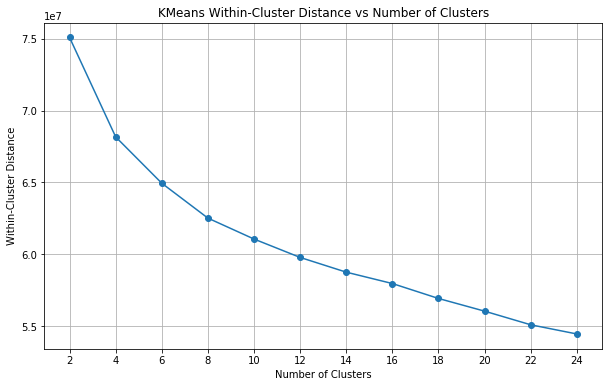

In [24]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 6))
plt.plot(centers, scores, marker='o')
plt.title('KMeans Within-Cluster Distance vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Distance')
plt.xticks(centers)
plt.grid(True)
plt.show()

In [21]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Set a number of clusters
n_clusters = 8
# Create a new instance of KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Fit the data
kmeans.fit(data_pca)
# Get cluster predictions
azdias_preds = kmeans.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

The elbows of the plot isn't as obvious as I would like, but it appears that around 8 clusters there is a slight drop off in variance. This is where we will segment the population. 8 clusters will still give us insight into the data while preserving resources and time. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [22]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
# Create copies of the datasets to work with
customers_clean = customers.copy()

In [23]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Preprocessing and feature transformation of the customers dataset
customers_clean, feat_info_clean = clean_data(customers_clean, feat_info_clean)
customers_clean.shape

(142555, 120)

In [24]:
# Search for differences in the features_clean and customers_clean columns
set(azdias_clean.columns) - set(customers_clean.columns)

{'GEBAEUDETYP_5.0'}

In [25]:
set(customers_clean.columns) - set(azdias_clean.columns)

{'AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'TITEL_KZ'}

In [26]:
# Add the feature missing from customers_clean
customers_clean['GEBAEUDETYP_5.0'] = 0
# Create a list of features missing from azdias_clean
drop_list = ['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'TITEL_KZ']
# Drop the features missing from azdias_clean
customers_clean = customers_clean.drop(columns=drop_list, axis=1)

In [27]:
# Check for total number of NaN values
total_nans = customers_clean.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {total_nans}")

Total NaN values in the DataFrame: 127565


In [28]:
# Use the imputer to transform the data
customers_imputer = imputer.transform(customers_clean)
customers_clean = pd.DataFrame(customers_imputer, columns=customers_clean.columns)

In [29]:
# Check for total number of NaN values after imputing
print('NaN values in the dataset after filling NaNs:', customers_clean.isna().sum().sum())

NaN values in the dataset after filling NaNs: 0


In [31]:
# Scale the data
cust_scaled = scaler.transform(customers_clean)
# Convert scaled data back to DataFrame
cust_scaled = pd.DataFrame(cust_scaled, columns=customers_clean.columns)
# Transform the data with PCA
customers_pca = pca.transform(cust_scaled)
# Cluster the data using KMeans
customers_preds = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

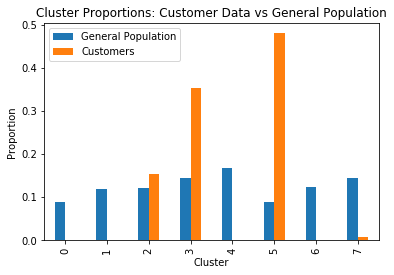

In [32]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Add the 'cluster' column to the dataframes
azdias_clean['cluster'] = azdias_preds
customers_clean['cluster'] = customers_preds

# Calculate cluster proportions
cluster_counts_general = azdias_clean['cluster'].value_counts(normalize=True)
cluster_counts_customers = customers_clean['cluster'].value_counts(normalize=True)

# Convert to DataFrame for easier plotting
comparison_df = pd.DataFrame({'General Population': cluster_counts_general, 'Customers': cluster_counts_customers})

# Plot
comparison_df.plot(kind='bar')
plt.title('Cluster Proportions: Customer Data vs General Population')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

In [33]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Calculate the difference in proportions
difference_in_proportions = cluster_counts_customers - cluster_counts_general

# Sort the differences to find the most overrepresented clusters in the customer data
overrepresented_cluster = difference_in_proportions.sort_values(ascending=False)

# Get the top cluster(s)
top_overrepresented_cluster = overrepresented_cluster.index[0]

# Now you can analyze the top_overrepresented_cluster further
print(f"The most overrepresented cluster in the customer data compared to the general population is Cluster {top_overrepresented_cluster}")

The most overrepresented cluster in the customer data compared to the general population is Cluster 5


In [34]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Sort the differences to find the most underrepresented clusters in the customer data
underrepresented_cluster = difference_in_proportions.sort_values(ascending=True)

# Get the top cluster(s)
top_underrepresented_cluster = underrepresented_cluster.index[0]

# Now you can analyze the top_underrepresented_cluster further
print(f"The most underrepresented cluster in the customer data compared to the general population is Cluster {top_underrepresented_cluster}")

The most underrepresented cluster in the customer data compared to the general population is Cluster 4


In [44]:
def compare_cluster_means(df1, df2, cluster_label, target_cluster):
    """
    Compare the mean of each feature between a specific cluster and all other clusters.

    Parameters:
    df1 (DataFrame): The DataFrame containing general population data and cluster labels.
    df2 (DataFrame): The DataFrame containing customer population data and cluster labels.
    cluster_label (str): The name of the column in 'data' that contains the cluster labels.
    target_cluster (int): The specific cluster to compare against the rest.

    Returns:
    df1_sorted (DataFrame): A DataFrame sorted by percentage changes between target clusters and other clusters
    for the general population data. 
    df2_sorted (DataFrame): A DataFrame sorted by percentage changes between target clusters and other clusters
    for the customer population data.
    """
    # Split the data into the target cluster and other clusters for both DataFrames
    target_data1 = df1[df1[cluster_label] == target_cluster]
    other_data1 = df1[df1[cluster_label] != target_cluster]
        
    target_data2 = df2[df2[cluster_label] == target_cluster]
    other_data2 = df2[df2[cluster_label] != target_cluster]
    
    # Calculate means for both DataFrames
    target_means1 = target_data1.mean()
    other_means1 = other_data1.mean()
        
    target_means2 = target_data2.mean()
    other_means2 = other_data2.mean()
    # Set parameters for which path to follow based on target_cluster
    
    # Calculate percentage change
    percentage1 = ((target_means1 - other_means1) / other_means1) * 100
    percentage2 = ((target_means2 - other_means2) / other_means2) * 100

    # Create DataFrames for comparison
    df1 = pd.DataFrame({
        'General_Mean_in_Cluster': target_means1,
        'General_Mean_in_Other_Clusters': other_means1,
        'Percentage_Change': percentage1
        })
    df2 = pd.DataFrame({
        'Customer_Mean_in_Cluster': target_means2,
        'Customer_Mean_in_Other_Clusters': other_means2,
        'Percentage_Change': percentage2
        })
    
    if target_cluster == top_overrepresented_cluster:
        # Sort the DataFrames by percentage change
        df1_sorted = df1.sort_values(by='Percentage_Change', ascending=False)
        df2_sorted = df2.sort_values(by='Percentage_Change', ascending=False)
    elif target_cluster == top_underrepresented_cluster:
        # Sort the DataFrames by percentage change
        df1_sorted = df1.sort_values(by='Percentage_Change', ascending=True)
        df2_sorted = df2.sort_values(by='Percentage_Change', ascending=True)

    return df1_sorted, df2_sorted

In [55]:
azdias_over_means, customers_over_means = compare_cluster_means(azdias_clean, customers_clean, 'cluster', top_overrepresented_cluster)
azdias_over_means.head(30)

,General_Mean_in_Cluster,General_Mean_in_Other_Clusters,Percentage_Change
ZABEOTYP_5,0.396534,0.075528,425.016561
NATIONALITAET_KZ_2.0,0.217464,0.066570,226.671941
FINANZTYP_4,0.180848,0.058999,206.528711
FINANZTYP_1,0.601136,0.210194,185.991180
CAMEO_DEUG_2015_9,0.315457,0.115335,173.513685
KBA05_ANTG4,0.584854,0.256156,128.319461
LP_STATUS_GROB_1.0,0.815361,0.358539,127.412232
SHOPPER_TYP_0.0,0.296598,0.143378,106.863883
KBA05_ANTG3,1.071937,0.534889,100.403753
ANZ_HAUSHALTE_AKTIV,14.768088,7.522355,96.322660


In [56]:
customers_over_means.head(30)

,Customer_Mean_in_Cluster,Customer_Mean_in_Other_Clusters,Percentage_Change
FINANZTYP_4,0.023046,0.003411,575.620968
FINANZTYP_3,0.057630,0.010112,469.918296
LP_FAMILIE_GROB_4.0,0.095445,0.020237,371.628833
CJT_GESAMTTYP_3.0,0.254866,0.076554,232.923544
ZABEOTYP_5,0.010792,0.003681,193.198094
ZABEOTYP_1,0.542765,0.232035,133.915728
NATIONALITAET_KZ_2.0,0.023631,0.010287,129.712298
SHOPPER_TYP_0.0,0.283907,0.143265,98.168677
cluster,5.000000,2.777659,80.007669
SHOPPER_TYP_1.0,0.335410,0.192032,74.663665


In [57]:
azdias_under_means, customers_under_means = compare_cluster_means(azdias_clean, customers_clean, 'cluster', top_underrepresented_cluster)
azdias_under_means.head(30)

,General_Mean_in_Cluster,General_Mean_in_Other_Clusters,Percentage_Change
GEBAEUDETYP_5.0,0.000000,0.000001,-100.000000
ZABEOTYP_5,0.000499,0.125124,-99.601386
FINANZTYP_4,0.001782,0.083623,-97.868594
FINANZTYP_1,0.006704,0.293215,-97.713650
KBA05_ANTG4,0.011582,0.340785,-96.601524
PRAEGENDE_JUGENDJAHRE_movement,0.011831,0.256922,-95.395137
GREEN_AVANTGARDE,0.011831,0.256922,-95.395137
LP_STATUS_GROB_1.0,0.033300,0.473196,-92.962833
CAMEO_DEUG_2015_9,0.012638,0.157537,-91.977950
ANZ_HH_TITEL,0.004357,0.046894,-90.709188


In [54]:
customers_under_means.head(30)

,Customer_Mean_in_Cluster,Customer_Mean_in_Other_Clusters,Percentage_Change
LP_STATUS_GROB_5.0,0.000000,0.364485,-100.000000
CAMEO_DEUG_2015_7,0.000000,0.074160,-100.000000
CAMEO_DEUG_2015_8,0.000000,0.091657,-100.000000
NATIONALITAET_KZ_3.0,0.000000,0.010016,-100.000000
FINANZTYP_3,0.000000,0.032950,-100.000000
FINANZTYP_4,0.000000,0.012847,-100.000000
ZABEOTYP_5,0.000000,0.007101,-100.000000
FINANZTYP_1,0.000000,0.028461,-100.000000
GREEN_AVANTGARDE,0.000000,0.494275,-100.000000
CAMEO_DEUG_2015_9,0.000000,0.044898,-100.000000


### Discussion 3.3: Compare Customer Data to Demographics Data

The most overrepresented cluster in the customers dataset is cluster 5. This cluster can be described as a group of people who appreciate the right advertising. They are also very socially conscience in reference to energy. Conversely, they appear to have lower affinities for culture, religion and familiy. This cluster is centered mostly around person-level features. Let me expand on this by going over the top feature influences:
* ZABEOTYP_1: Considered very green in regards to energy consumption.
* CJT_GESAMTTYP_3.0: Advertising-interested store shopper.
* SHOPPER_TYP_0.0: Shoppers who are driven by pleasure and enjoyment in their shopping experiences and whose motivations are largely influenced by external factors rather than internal needs or desires.  Also can be trend-driven, seeking out the latest items that are popular or highly recommended in their social circles.
* SHOPPER_TYP_1.0: A consumer who finds the shopping experience to be generally stressful. These indivisuals appreciate clear information from advertising sources. They could also find it more relaxing to buy products recommended by friends and family. 
* SEMIO_KULT, SEMIO_REL, SEMIO_FAM: A person's affinity for culture, religion, and familiy. 

So, we can see that this cluster is heavily influenced by advertising and shopping types. Seeing that they are energy conscience can make sense with that, as well. It is a newer, more exciting, and well advertised product. People in these categories are more likely to be responsive to the companies advertising efforts. 
    
Cluster 4 is underrepresented in the customer dataset. Cluster 4 is made of people who prefer privacy in their financial matters. There are no top earners in this group. They  more than likey live in rural areas, as well. Here are the most important features for the cluster:
* LP_STATUS_GROB_5.0: Top earners.
* GREEN_AVANTGARDE: Part of an environmental sustainability youth group.
* KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4: Number of homes at all levels in RR3 micro-cell.
* ANZ_HAUSHALTE_AKTIV: Number of households in the building.
* FINANZTYP_6: A financially inconspicuous person. Prefers stability, privacy, and discretion. 

Looking at this data we can see that this cell is void of any top earners. The fact that the people in this cluster also did not attend an environmental sustainability youth group pairs with this, as it is better suited for higher incomes. There is a lower share of all family homes in this cluster. That along with the number of households per building dropping 69% leads me to believe this group lives in rural areas. Finally, being financially private is another leading influence. This together tells us that this cluster would be less likely to be attracted from advertising campaigns. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.